# Vehicle Detection
---
John Bang - 4/28/17
### As a part of the Udacity Self Driving Car Engineer Nanodegree program, we use computer vision and supervised machine learning to detect the presence and location of vehicles on the road from the perspective of a moving car.

---

**Vehicle Detection Project**

The goals / steps of this project are the following:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier\*
2. Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.\*
3. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
4. Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
5. Estimate a bounding box for vehicles detected.

\**Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.*

## Prepare Training Image Lists

8792 vehicle images
8968 non-vehicle images


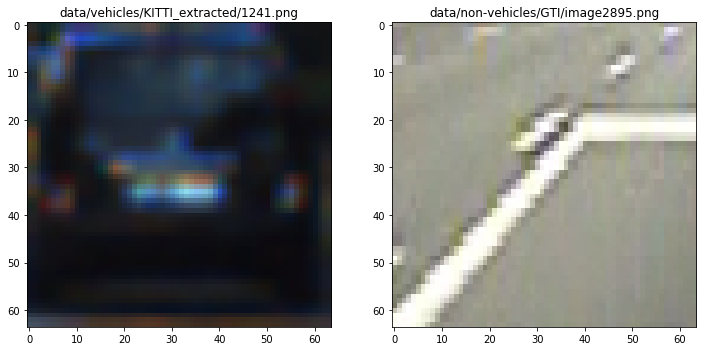

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# Make lists of car and notcar files
cars = glob.glob('data/vehicles/*/*.png')
notcars = glob.glob('data/non-vehicles/*/*.png')

# Print number of each class
print(len(cars), "vehicle images")
print(len(notcars), "non-vehicle images")

# Plot a random example of each class
fig, ax = plt.subplots(1,2, figsize=(12,6))

plt.sca(ax[0])
car_example = np.random.choice(cars)
# car_example = 'data/vehicles/KITTI_extracted/4831.png'
plt.imshow(mpimg.imread(car_example))
plt.title(car_example)
plt.sca(ax[1])
notcar_example = np.random.choice(notcars)
# notcar_example = 'data/non-vehicles/Extras/extra2371.png'
plt.imshow(mpimg.imread(notcar_example))
plt.title(notcar_example)

fig.savefig('output_images/train_images.jpg')

## HOG and color feature extraction and Linear SVC training

### feature extraction functions

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import itertools
import pandas as pd

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_size=None, hist_bins=None):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        if file.endswith('.png'):
            image = np.uint8(image*255)
        
        file_features = []

        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        file_features.append(hog_features)
        
        # Get optional color features
        if spatial_size is not None:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_bins is not None:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Linear SVC training

In [3]:
RUNSWEEP = False
TRAIN_CLASSIFIER = False

if TRAIN_CLASSIFIER:

    if RUNSWEEP:

        # Lists of parameters to permute
        colorspace_list = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
        orient_list = [6,9,12,15]
        pix_per_cell_list = [4,8,12,16]
        cell_per_block_list = [1,2,3,4]
        hog_channel_list = [0, 1, 2, 'ALL']
        spatials = [None,8,12,16,20,24,28,32]
        histbins = [None,20,24,28,32,36,40]

    else:

        # Best parameters found through parameter sweep
        colorspace_list = ['YUV']
        orient_list = [12]
        pix_per_cell_list = [16,8]
        cell_per_block_list = [2]
        hog_channel_list = ['ALL']
        spatials = [None,8]
        hist_bins_list = [None,28]


    # Construct list of parameter permutations
    params = itertools.product(colorspace_list, orient_list, pix_per_cell_list,
                               cell_per_block_list, hog_channel_list,
                               spatials, hist_bins_list)

    entries = [] # list to store test result dicts

    for colorspace, orient, pix_per_cell, cell_per_block, hog_channel, spatial, hist_bins in params:

        if spatial is not None:
            spatial = (spatial, spatial) # square size

        # initialize dict to store test result
        entry = {'colorspace':colorspace, 'orient':orient, 'pix_per_cell':pix_per_cell,
                 'cell_per_block':cell_per_block, 'hog_channel':hog_channel, 'spatial_size':spatial,
                 'hist_bins':hist_bins}

        print(entry)

        t=time.time()

        ########## Extract the features
        car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_size=spatial, hist_bins=hist_bins)
        notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_size=spatial, hist_bins=hist_bins)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to extract', len(cars) + len(notcars),'sets of features...')

        ########## Prepare feature vectors
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets (80/20 split)
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                            random_state=rand_state)

    #     # Add hard negative examples
    #     with open('pickles/hard_negatives.p', 'rb') as f:
    #         hard_negatives = pickle.load(f)
    #     hardneg_features = extract_features(notcars, cspace=colorspace, orient=orient, 
    #                             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
    #                             hog_channel=hog_channel, spatial_size=spatial, hist_bins=hist_bins)
    #     X_train = np.vstack((X_train, hardneg_features)).astype(np.float64)
    #     y_train = np.hstack((y_train, np.zeros(len(hardneg_features))))
    #     X = np.vstack((X, hardneg_features)).astype(np.float64)
    #     y = np.hstack((y, np.zeros(len(hardneg_features))))

        # Fit a per-column scaler
        # Create a scaler which imposes zero-mean, unit variance on the training set
        X_scaler = StandardScaler().fit(X_train)
        # Apply the scaler to X
        X_train_scaled = X_scaler.transform(X_train)

        print('Using:',orient,'orientations',pix_per_cell,
            'pixels per cell and', cell_per_block,'cells per block')
        print('Feature vector length:', len(X_train[0]))
        entry['nfeatures'] = len(X_train[0])

        ########## Train linear SVM classifier
        # Use a linear SVC 
        svc = LinearSVC()
        # Check the training time for the SVC
        t=time.time()
        svc.fit(X_train_scaled, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        entry['train_secs'] = round(t2-t, 2)

        ########## Test the classifier
        # Check the score of the SVC
        X_test_scaled = X_scaler.transform(X_test)
        entry['test_accy'] = round(svc.score(X_test_scaled, y_test), 4)
        print('Test Accuracy of SVC = ', entry['test_accy'])
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        entry['n_predict'] = n_predict
        print('My SVC predicts: ', svc.predict(X_test_scaled[0:n_predict]))
        print('For these',n_predict, 'labels: ', y_test[0:n_predict])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
        entry['predict_secs'] = round(t2-t, 5)
        print()

        ########### Fit scaler and train classifier with entire dataset
        X_scaler = StandardScaler().fit(X)
        entry['X_scaler'] = X_scaler
        X_scaled = X_scaler.transform(X)
        svc = LinearSVC()
        svc.fit(X_scaled, y)
        entry['svc'] = svc


        entries.append(entry) # append test result



    # create test result dataframe for parameter sweep analysis/documentation
    hog_classify_df = pd.DataFrame(entries)
    # pickle it for later use
    # hog_classify_df.to_pickle('pickles/hog_classify_df.p')
    # display it
    hog_classify_df

### Visualize Hog Features

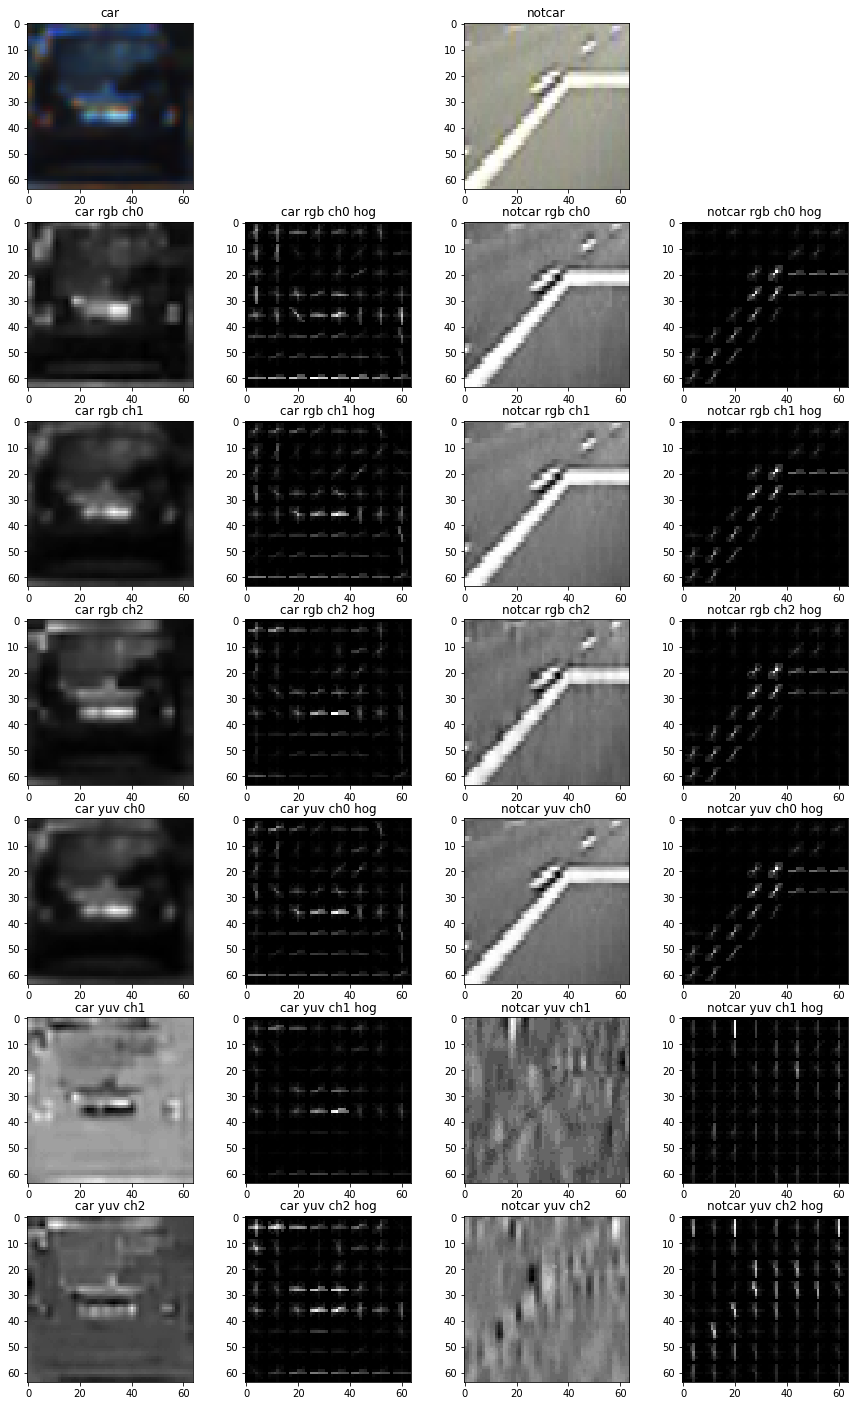

In [4]:
# Plot an example of HOG features for car and notcar, rgb and yuv
plt.close('all')
fig, ax = plt.subplots(7,4, figsize=(15, 25))

for image_idx, imagefile in enumerate([car_example, notcar_example]):
    
    if image_idx==0:
        titlestr0 = 'car'
    else:
        titlestr0 = 'notcar'

    image = mpimg.imread(imagefile)
    if imagefile.endswith('.png'):
        image = np.uint8(image*255)

    plt.sca(ax[0,0 + image_idx*2])
    plt.imshow(image)
    plt.title(titlestr0)
    fig.delaxes(ax[0,1 + image_idx*2])

    yuv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    for color_idx, img in enumerate([image, yuv_image]):
        
        if color_idx==0:
            titlestr1 = titlestr0 + ' rgb'
        else:
            titlestr1 = titlestr0 + ' yuv'
        
        for ch in range(3):
            _,hog_image = get_hog_features(img[:,:,ch], orient=12, pix_per_cell=8, cell_per_block=2, vis=True)

            titlestr2 = titlestr1 + ' ch' + str(ch)
            
            plt.sca(ax[color_idx*3 + ch + 1,0 + image_idx*2])
            plt.imshow(img[:,:,ch], cmap='gray')
            plt.title(titlestr2)
            plt.sca(ax[color_idx*3 + ch + 1,1 + image_idx*2])
            plt.imshow(hog_image, cmap='gray')
            plt.title(titlestr2 + ' hog')

fig.savefig('output_images/hog_example.jpg', bbox_inches='tight')

## Sliding Windows

In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
import numpy as np
import cv2


def convert_color(img, cspace='YUV'):
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    
    return feature_image


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, cells_per_step, svc, X_scaler, orient, pix_per_cell,
              cell_per_block, spatial_size, hist_bins, colorspace, draw_img=None, accept_all=False,
              draw_color=(0,0,255)):
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]

    ctrans_tosearch = convert_color(img_tosearch, colorspace)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    scores = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if spatial_size is not None:
                spatial_features = bin_spatial(subimg, size=spatial_size)
            else:
                spatial_features = np.array([])
            if not np.isnan(hist_bins):
                hist_features = color_hist(subimg, nbins=hist_bins)
            else:
                hist_features = np.array([])

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features, spatial_features, hist_features)).reshape(1, -1))   
            test_score = svc.decision_function(test_features)
            test_prediction = test_score > 0
            
            if test_prediction or accept_all:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                topleft = (xbox_left+xstart, ytop_draw+ystart)
                botright = (xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)
                if draw_img is not None:
                    cv2.rectangle(draw_img,topleft,botright,draw_color,6)
                bboxes.append((topleft, botright))
                scores.append(test_score)
                
    return bboxes, scores

X_scaler          StandardScaler(copy=True, with_mean=True, with...
cell_per_block                                                    2
colorspace                                                      YUV
hist_bins                                                        28
hog_channel                                                     ALL
n_predict                                                        10
nfeatures                                                      7332
orient                                                           12
pix_per_cell                                                      8
predict_secs                                                0.00295
spatial_size                                                 (8, 8)
svc               LinearSVC(C=1.0, class_weight=None, dual=True,...
test_accy                                                    0.9938
train_secs                                                      3.3
Name: 7, dtype: object


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


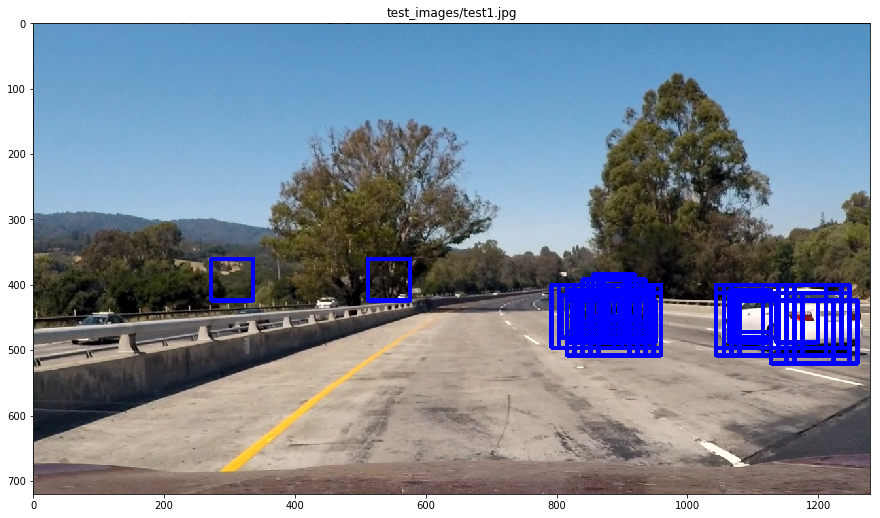

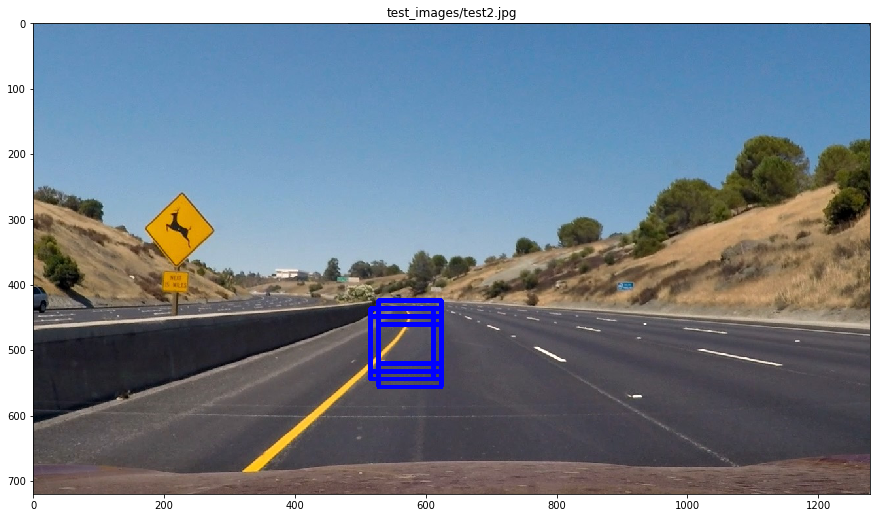

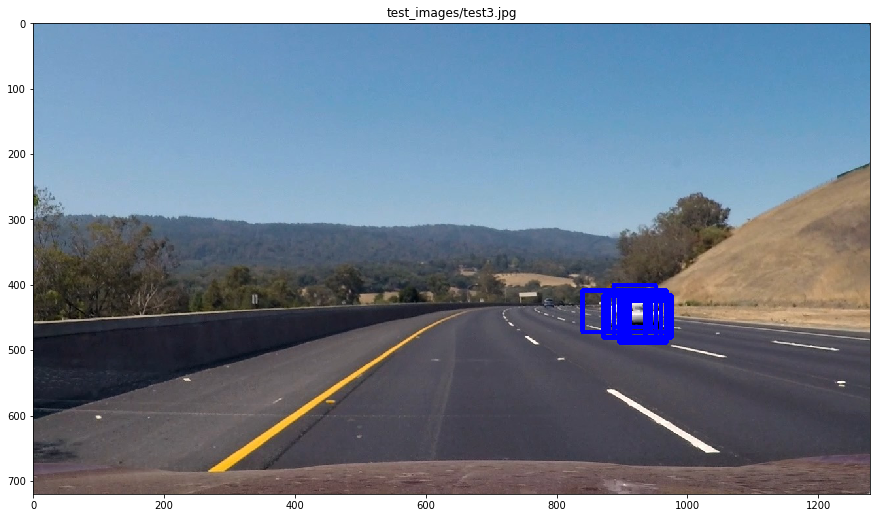

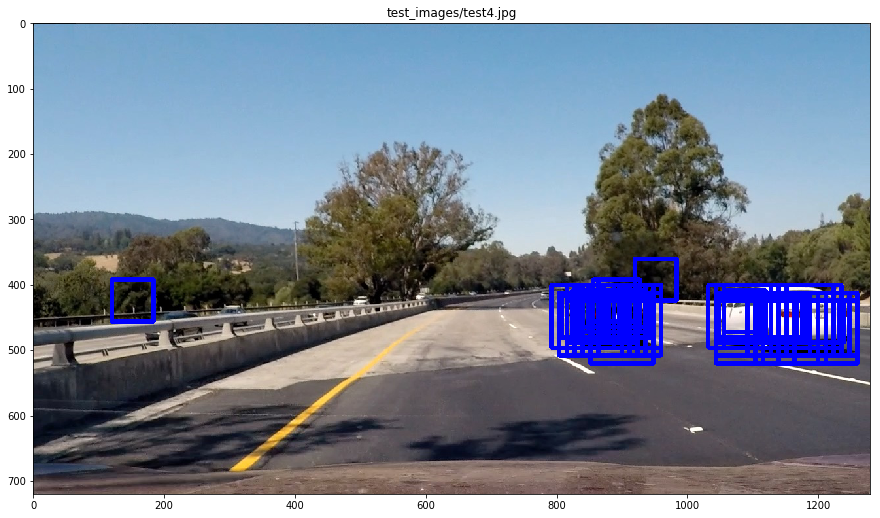

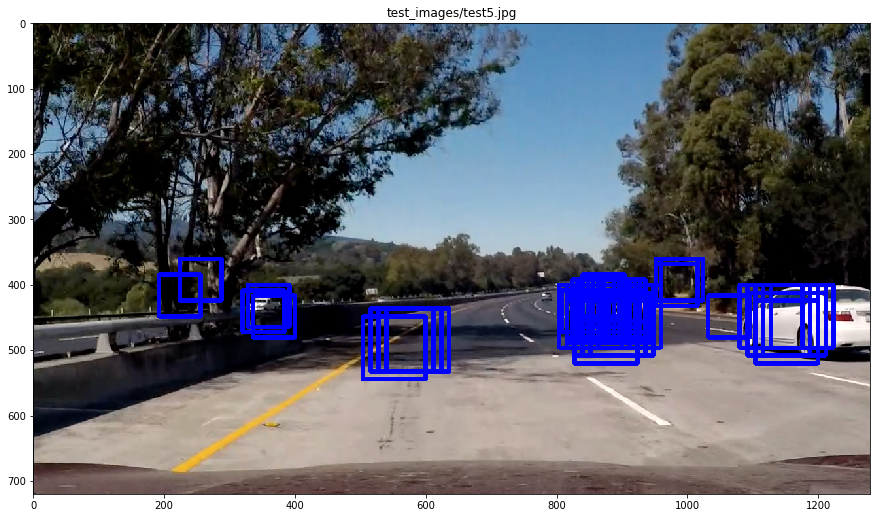

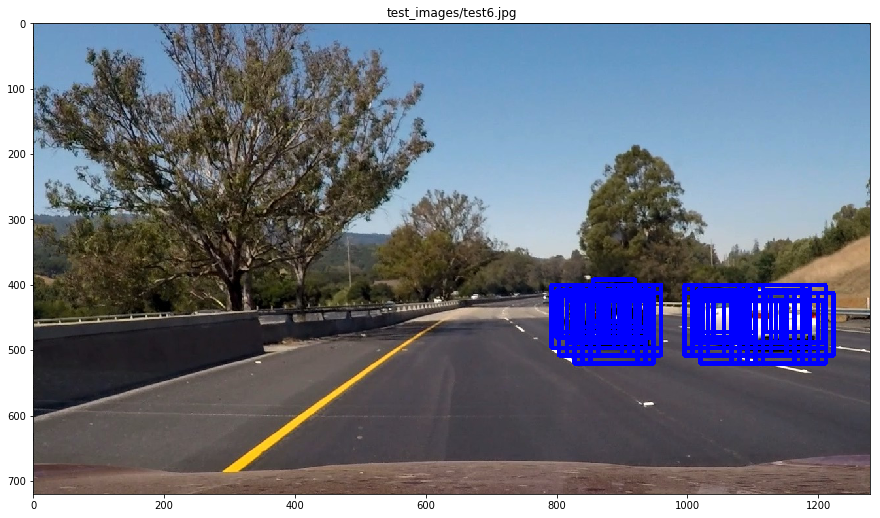

In [6]:
import pandas as pd

plt.close('all')

# Get best classifier and corresponding feature extraction params
df = pd.read_pickle('pickles/hog_classify_df.p')
# df.sort_values(['test_accy','predict_secs','train_secs'], ascending=[False,True,True], inplace=True)
params = df.iloc[7]
print(params)

wgroups = [
     {'ystart':360, 'ystop':500, 'xstart':0, 'xstop':1280, 'scale':1, 'cells_per_step':1},
#     {'ystart':390, 'ystop':500, 'xstart':200, 'xstop':1080, 'scale':1.1, 'cells_per_step':1},
#     {'ystart':390, 'ystop':500, 'xstart':200, 'xstop':1080, 'scale':0.9, 'cells_per_step':1},
     {'ystart':400, 'ystop':600, 'xstart':0, 'xstop':1280, 'scale':1.5, 'cells_per_step':1}
#     {'ystart':560, 'ystop':700, 'xstart':0, 'xstop':1280, 'scale':2.0, 'cells_per_step':1}
#                 {'ystart':300, 'ystop':700, 'xstart':0, 'xstop':1280, 'scale':1.0, 'cells_per_step':1},
#                 {'ystart':300, 'ystop':700, 'xstart':0, 'xstop':1280, 'scale':1.0, 'cells_per_step':1},
#                 {'ystart':300, 'ystop':700, 'xstart':0, 'xstop':1280, 'scale':1.0, 'cells_per_step':1}
    ]

examplefiles = glob.glob('test_images/*.jpg')# + glob.glob('test_images/project_video/*.jpg')
examplefiles.sort()
bbox_dict = {}
for examplefile in examplefiles:
    
    img = mpimg.imread(examplefile)

    if examplefile.endswith('.png'):
        img = np.uint8(img*255)
    
    out_img = img.copy()
    bbox_dict[examplefile] = {'bboxes':[],'scores':[]}
    
    for wgroup, draw_color in zip(wgroups,[(0,255,0),(255,0,0)]):
        ystart = wgroup['ystart']
        ystop = wgroup['ystop']
        xstart = wgroup['xstart']
        xstop = wgroup['xstop']
        scale = wgroup['scale']
        cells_per_step = wgroup['cells_per_step']
        bboxes, scores = find_cars(img, ystart, ystop, xstart, xstop, scale, cells_per_step, params.svc, params.X_scaler, params.orient,
                                   params.pix_per_cell, params.cell_per_block, params.spatial_size,
                                   params.hist_bins, params.colorspace, out_img)
        bbox_dict[examplefile]['bboxes'].extend(bboxes)
        bbox_dict[examplefile]['scores'].extend(scores)
        
    
    plt.figure(figsize=(15,10))
    plt.imshow(out_img)
    plt.title(examplefile)
    plt.gcf().savefig('output_images/' + examplefile.split('/')[-1].split('.')[0] + '_windowed.jpg')

### Merge scales using heatmap thresholding

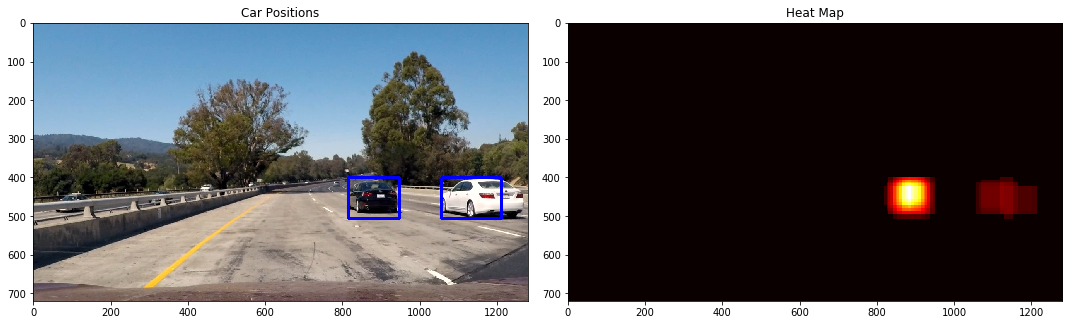

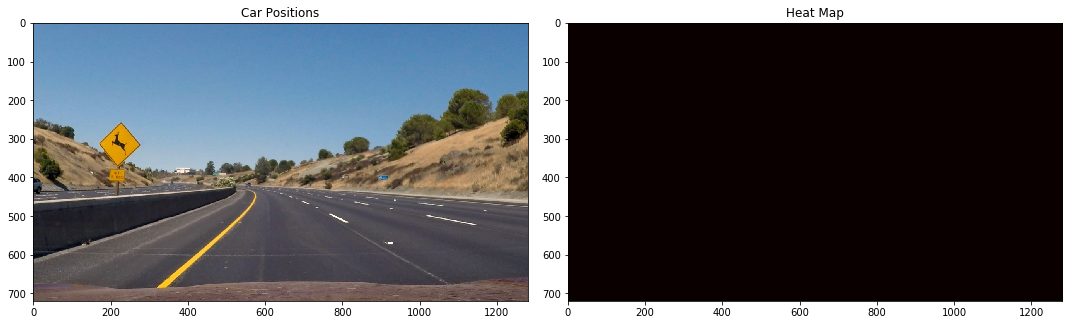

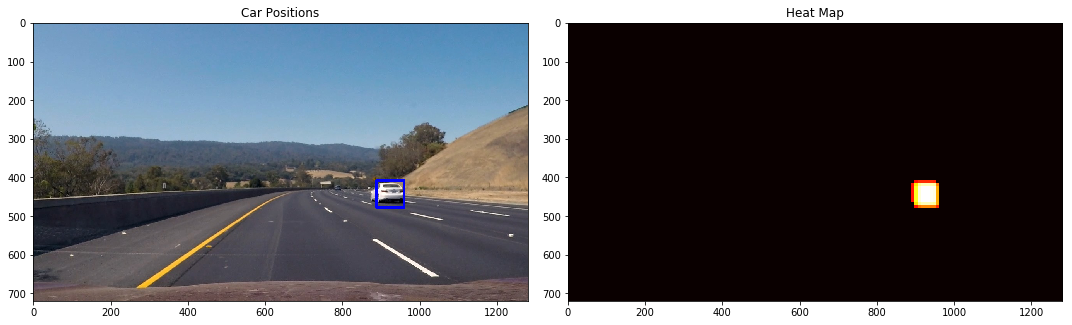

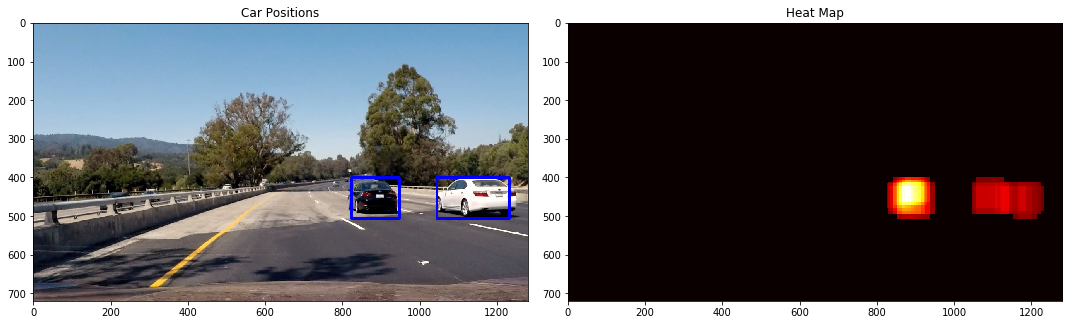

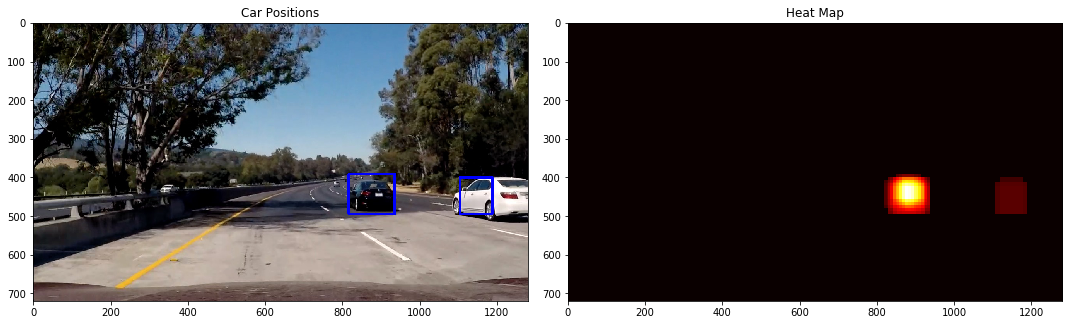

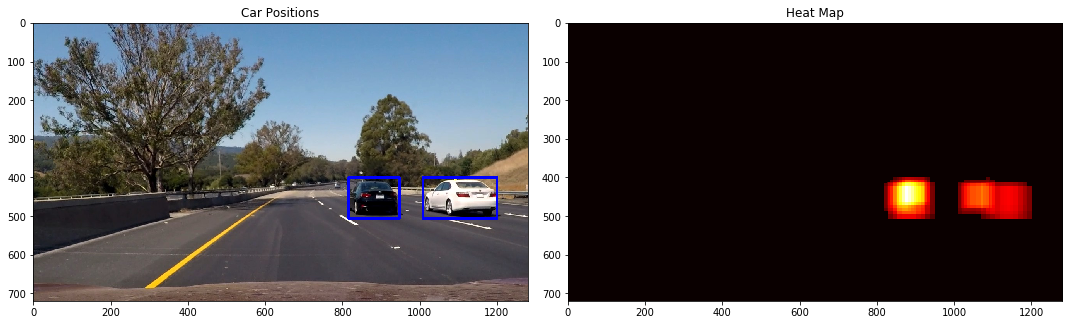

In [7]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label


def add_heat(heatmap, bbox_list, score_list=None):
    # Iterate through list of bboxes
    for box, score in zip(bbox_list, score_list):
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += score

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heatthresh = 4

for examplefile in examplefiles:
    
    # Read in image
    image = mpimg.imread(examplefile)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bbox_dict[examplefile]['bboxes'],bbox_dict[examplefile]['scores'])

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, heatthresh)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure(figsize=(15,8))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    fig.savefig('output_images/' + examplefile.split('/')[-1].split('.')[0] + '_heat.jpg')

## Define Pipeline and run on video

In [8]:
# Print active parameters
print(params)
print(wgroups)
print('heatthresh', heatthresh)

avg_heat = None

def process_image(image):
    
    global avg_heat
    
    bbox_dict = {'bboxes':[],'scores':[]}
    
    for wgroup in wgroups:
        ystart = wgroup['ystart']
        ystop = wgroup['ystop']
        xstart = wgroup['xstart']
        xstop = wgroup['xstop']
        scale = wgroup['scale']
        cells_per_step = wgroup['cells_per_step']
        
        bboxes, scores = find_cars(img, ystart, ystop, xstart, xstop, scale, cells_per_step, params.svc,
                                   params.X_scaler, params.orient,
                                   params.pix_per_cell, params.cell_per_block, params.spatial_size,
                                   params.hist_bins, params.colorspace, out_img)
        bbox_dict['bboxes'].extend(bboxes)
        bbox_dict['scores'].extend(scores)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bbox_dict['bboxes'],bbox_dict['scores'])
    
    if avg_heat is None:
        avg_heat = heat
        return image
    else:
        avg_heat = 0.33*heat + 0.67*avg_heat

    # Apply threshold to help remove false positives
    heat = apply_threshold(avg_heat, heatthresh)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

X_scaler          StandardScaler(copy=True, with_mean=True, with...
cell_per_block                                                    2
colorspace                                                      YUV
hist_bins                                                        28
hog_channel                                                     ALL
n_predict                                                        10
nfeatures                                                      7332
orient                                                           12
pix_per_cell                                                      8
predict_secs                                                0.00295
spatial_size                                                 (8, 8)
svc               LinearSVC(C=1.0, class_weight=None, dual=True,...
test_accy                                                    0.9938
train_secs                                                      3.3
Name: 7, dtype: object
[{'scale': 1, 'xstart': 0

In [219]:
from moviepy.editor import VideoFileClip
video_output = 'test_video_out.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4



 97%|█████████▋| 38/39 [01:19<00:02,  2.06s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 1min 19s, sys: 92 ms, total: 1min 19s
Wall time: 1min 20s


In [220]:
from moviepy.editor import VideoFileClip
avg_heat = None
video_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



100%|█████████▉| 1260/1261 [44:09<00:02,  2.09s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 44min 31s, sys: 3.36 s, total: 44min 35s
Wall time: 44min 10s


#### Scratch / quick utility cells

In [222]:
def save_examples_from_video():
    video1 = VideoFileClip('project_video.mp4')
    example_seconds = range(26,30)
    for s in example_seconds:
        video1.save_frame('test_images/project_video/' + str(int(s + 0.5)) + '.jpg', s)
save_examples_from_video()
glob.glob('test_images/project_video/*.jpg')

['test_images/project_video/29.jpg',
 'test_images/project_video/27.jpg',
 'test_images/project_video/28.jpg',
 'test_images/project_video/26.jpg']

v1 PARams

X_scaler          StandardScaler(copy=True, with_mean=True, with...
cell_per_block                                                    2
colorspace                                                      YUV
hist_bins                                                        28
hog_channel                                                     ALL
n_predict                                                        10
nfeatures                                                      7332
orient                                                           12
pix_per_cell                                                      8
predict_secs                                                0.00295
spatial_size                                                 (8, 8)
svc               LinearSVC(C=1.0, class_weight=None, dual=True,...
test_accy                                                    0.9938
train_secs                                                      3.3
Name: 7, dtype: object
[{'cells_per_step': 1, 'xstop': 1080, 'ystop': 500, 'ystart': 360, 'scale': 1.0, 'xstart': 200}, {'cells_per_step': 1, 'xstop': 1280, 'ystop': 600, 'ystart': 400, 'scale': 1.5, 'xstart': 0}]
heatthresh 4

In [304]:
import tabulate
hog_classify_df_best10 = pd.read_csv('lessons/dataframes/hog_classify_df_best10.csv')
print(tabulate.tabulate(hog_classify_df_best10, hog_classify_df.keys(), tablefmt='pipe', showindex='never'))
hog_classify_df = pd.read_pickle('pickles/hog_classify_df.p')
print(tabulate.tabulate(hog_classify_df, hog_classify_df.keys(), tablefmt='pipe', showindex='never'))
hog_classify_df

|   cell_per_block | colorspace   |   extract_secs | hog_channel   |   n_predict |   nfeatures |   orient |   pix_per_cell |   predict_secs |   test_accy |   train_secs |
|-----------------:|:-------------|---------------:|:--------------|------------:|------------:|---------:|---------------:|---------------:|------------:|-------------:|
|                2 | YUV          |           0.05 | ALL           |          10 |        7056 |       12 |              8 |        0.00296 |      0.9909 |         3.73 |
|                2 | YCrCb        |           0.09 | ALL           |          10 |       32400 |       12 |              4 |        0.00268 |      0.99   |        15.64 |
|                3 | YCrCb        |           0.05 | ALL           |          10 |       14580 |       15 |              8 |        0.00276 |      0.9875 |         7.58 |
|                2 | YUV          |           0.04 | ALL           |          10 |        1296 |       12 |             16 |        0.00242 |    

X_scaler  cell_per_block  \
0  StandardScaler(copy=True, with_mean=True, with...               2   
1  StandardScaler(copy=True, with_mean=True, with...               2   
2  StandardScaler(copy=True, with_mean=True, with...               2   
3  StandardScaler(copy=True, with_mean=True, with...               2   
4  StandardScaler(copy=True, with_mean=True, with...               2   
5  StandardScaler(copy=True, with_mean=True, with...               2   
6  StandardScaler(copy=True, with_mean=True, with...               2   
7  StandardScaler(copy=True, with_mean=True, with...               2   

  colorspace  hist_bins hog_channel  n_predict  nfeatures  orient  \
0        YUV        NaN         ALL         10       1296      12   
1        YUV       28.0         ALL         10       1380      12   
2        YUV        NaN         ALL         10       1488      12   
3        YUV       28.0         ALL         10       1572      12   
4        YUV        NaN         ALL         10       7056      12   
5        YUV       28.0         ALL         10       7140      12   
6        YUV        NaN         ALL         10       7248      12   
7        YUV       28.0         ALL         10       7332      12   

   pix_per_cell  predict_secs spatial_size  \
0            16       0.00281         None   
1            16       0.00277         None   
2            16       0.00244       (8, 8)   
3            16       0.00266       (8, 8)   
4             8       0.00306         None   
5             8       0.00215         None   
6             8       0.00233       (8, 8)   
7             8       0.00295       (8, 8)   

                                                 svc  test_accy  train_secs  
0  LinearSVC(C=1.0, class_weight=None, dual=True,...     0.9862        2.00  
1  LinearSVC(C=1.0, class_weight=None, dual=True,...     0.9921        1.85  
2  LinearSVC(C=1.0, class_weight=None, dual=True,...     0.9896        2.17  
3  LinearSVC(C=1.0, class_weight=None, dual=True,...     0.9927        2.17  
4  LinearSVC(C=1.0, class_weight=None, dual=True,...     0.9921        3.65  
5  LinearSVC(C=1.0, class_weight=None, dual=True,...     0.9947        3.56  
6  LinearSVC(C=1.0, class_weight=None, dual=True,...     0.9910        8.80  
7  LinearSVC(C=1.0, class_weight=None, dual=True,...     0.9938        3.30

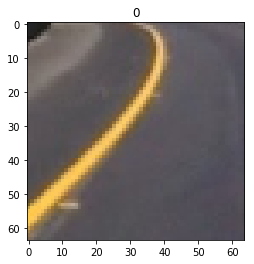

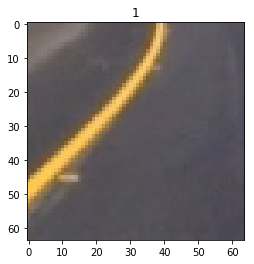

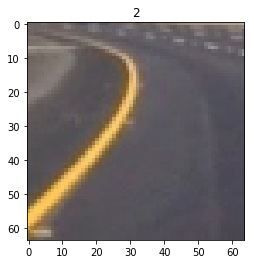

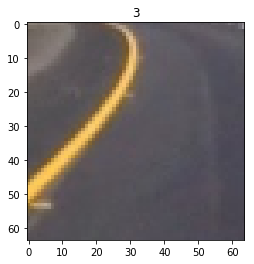

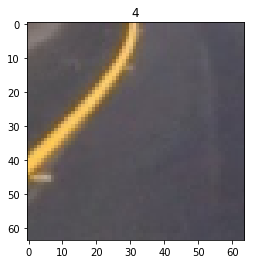

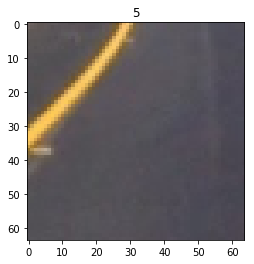

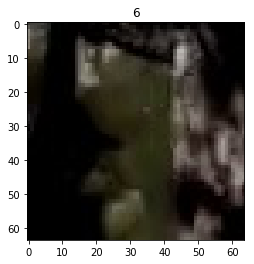

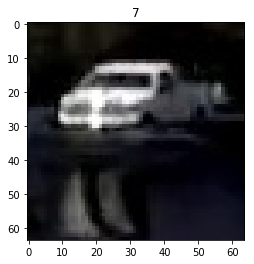

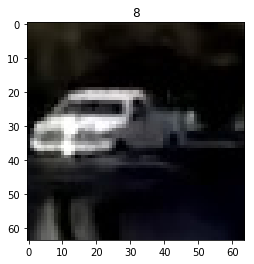

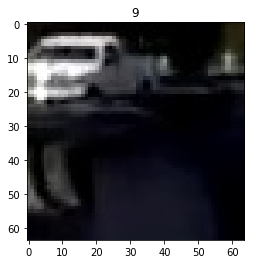

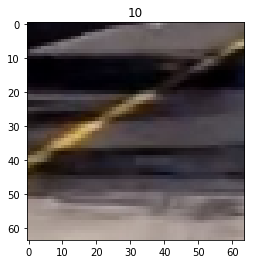

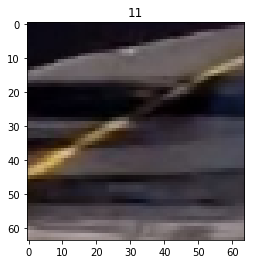

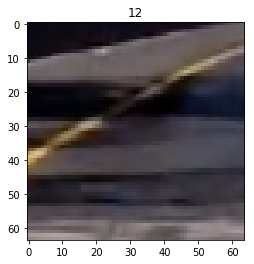

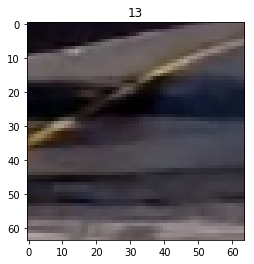

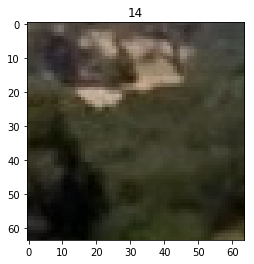

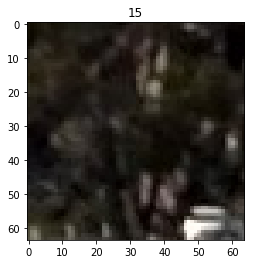

In [251]:
hard_negatives = []
index = 0
for testfile, bb_dict in bbox_dict.items():
    this_image = mpimg.imread(testfile)
    for topleft, botright in bb_dict['bboxes']:
        if topleft[0] < 700:
            # Extract the image patch
            subimg = cv2.resize(this_image[topleft[1]:botright[1], topleft[0]:botright[0]], (64,64))
            hard_negatives.append(subimg)
            plt.figure()
            plt.imshow(subimg)
            plt.title(str(index))
            index += 1
hard_negatives = hard_negatives[:7] + hard_negatives[10:]
            
import pickle

with open('pickles/hard_negatives.p', 'wb') as f:
    pickle.dump(hard_negatives, f)